In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.7.4.2 --quiet
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"erickumara","key":"ef3183b6e235dac70c2d15665a8216d6"}')

!chmod 600 /root/.kaggle/kaggle.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 4.4 MB/s eta 0:00:00


In [2]:
# Datasets
# https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset 7 columns
# https://www.kaggle.com/datasets/llabhishekll/fraud-email-dataset 2 columns

!mkdir '/content/data'

!kaggle datasets download -d naserabdullahalam/phishing-email-dataset
!unzip -qo 'phishing-email-dataset.zip' -d '/content/data'
!rm 'phishing-email-dataset.zip'

!kaggle datasets download -d llabhishekll/fraud-email-dataset
!unzip -qo 'fraud-email-dataset.zip' -d '/content/data'
!rm 'fraud-email-dataset.zip'

Dataset URL: https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset
License(s): CC-BY-SA-4.0
Dataset URL: https://www.kaggle.com/datasets/llabhishekll/fraud-email-dataset
License(s): unknown


In [3]:
import os
import requests
import tarfile
import email
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import BertTokenizerFast


data_path = "/content/data"

all_df = []

for file in os.listdir(data_path):
    df = pd.read_csv(os.path.join(data_path, file))

    # Normalizing all datasets to columns: body, label
    if {'body', 'label'}.issubset(df.columns):
        pass
    elif {'Text', 'Class'}.issubset(df.columns):
        df = df.rename(columns={'Text':'body','Class':'label'})
    elif {'text_combined','label'}.issubset(df.columns):
        df = df.rename(columns={'text_combined':'body'})
    elif 'message' in df.columns:
        df = df.rename(columns={'message':'body'})

    df = df[['body','label']]
    all_df.append(df)

    print(f"Loaded: {file}")
    print(df.head(1))
    print("-"*40)

final_df = pd.concat(all_df, ignore_index=True)
final_df.dropna(inplace=True)
final_df['label'] = final_df['label'].astype(int)

final_df.head()

Loaded: SpamAssasin.csv
                                                body  label
0  Date:        Wed, 21 Aug 2002 10:54:46 -0500  ...      0
----------------------------------------
Loaded: fraud_email_.csv
                                                body  label
0  Supply Quality China's EXCLUSIVE dimensions at...      1
----------------------------------------
Loaded: Nazario.csv
                                                body  label
0  This text is part of the internal format of yo...      1
----------------------------------------
Loaded: Nigerian_Fraud.csv
                                                body  label
0  FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...      1
----------------------------------------
Loaded: Ling.csv
                                                body  label
0  content - length : 3386 apple-iss research cen...      0
----------------------------------------
Loaded: Enron.csv
                                                body  label
0  (

,body,label
0,"Date: Wed, 21 Aug 2002 10:54:46 -0500 ...",0
1,"Martin A posted:\nTassos Papadopoulos, the Gre...",0
2,Man Threatens Explosion In Moscow \n\nThursday...,0
3,Klez: The Virus That Won't Die\n \nAlready the...,0
4,"> in adding cream to spaghetti carbonara, whi...",0


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

BASE_DIR = "/content/drive/MyDrive/email_bert"
TOKENIZER_PATH = os.path.join(BASE_DIR, "tokenizer", "bert-email-vocab.txt")
MODEL_PATH = os.path.join(BASE_DIR, "55M_Bert.pth")

class BERTSmall(nn.Module):
    def __init__(self, vocab, d_model=512, layers=8, heads=8, seq_len=64):
        super().__init__()
        self.d_model = d_model
        self.emb = nn.Embedding(vocab, d_model)
        self.pos = nn.Embedding(seq_len, d_model)
        self.seg = nn.Embedding(2, d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=heads,
            dim_feedforward=d_model * 3,
            batch_first=True,
            activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=layers)

        # heads used during pretraining (we keep them so checkpoint loads)
        self.mlm = nn.Linear(d_model, vocab)
        self.nsp = nn.Linear(d_model, 2)

    def forward(self, ids, seg, return_hidden=False):
        b, L = ids.shape
        pos = torch.arange(L, device=ids.device).unsqueeze(0)
        x = self.emb(ids) + self.pos(pos) + self.seg(seg)
        x = self.encoder(x)

        if return_hidden:
            return x  # (B, L, d_model)

        mlm_logits = self.mlm(x)
        nsp_logits = self.nsp(x[:, 0])
        return mlm_logits, nsp_logits

class BERTSmallSpamClassifier(nn.Module):
    def __init__(self, bert_backbone: BERTSmall):
        super().__init__()
        self.bert = bert_backbone
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(512, 1)  # 512 because d_model=512

    def forward(self, input_ids, token_type_ids):
        # get hidden states from BERTSmall
        hidden = self.bert(input_ids, token_type_ids, return_hidden=True)
        cls_repr = hidden[:, 0]  # [CLS] token
        x = self.dropout(cls_repr)
        logits = self.classifier(x)
        return logits

tokenizer = BertTokenizerFast(
        vocab_file=TOKENIZER_PATH,
        lowercase=True,
        strip_accents=False
    )

vocab_size = len(tokenizer)
bert_small = BERTSmall(vocab=vocab_size)

print("Loading pre-trained weights from:", MODEL_PATH)
state = torch.load(MODEL_PATH, map_location="cpu")
bert_small.load_state_dict(state)
print("✓ Loaded weights.")
print("Loading pre-trained weights from:", MODEL_PATH)
state = torch.load(MODEL_PATH, map_location="cpu")

Mounted at /content/drive
Loading pre-trained weights from: /content/drive/MyDrive/email_bert/55M_Bert.pth
✓ Loaded weights.
Loading pre-trained weights from: /content/drive/MyDrive/email_bert/55M_Bert.pth


In [5]:
total_params = sum(p.nelement() for p in bert_small.parameters())

print(f"Total parameters in bert_small: {total_params:,}")

Total parameters in bert_small: 51,805,490


In [6]:
X = final_df['body'].astype(str).values
y = final_df['label'].values

# Train vs temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Validation vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

len(X_train), len(X_val), len(X_test)


(141519, 17690, 17690)

In [7]:
class SpamEmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        enc = self.tok(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        input_ids = enc["input_ids"].squeeze(0)
        token_type_ids = enc["token_type_ids"].squeeze(0)

        return {
            "input_ids": input_ids,
            "token_type_ids": token_type_ids,
            "labels": torch.tensor(label, dtype=torch.float),
        }

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32 # Use the same batch size as your training/evaluation loop or set a new one
MAX_LEN = 64

# 1. Create PyTorch Dataset and DataLoader for the dedicated test set
test_dataset = SpamEmailDataset(X_test, y_test, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Test set size: {len(X_test)} samples")
print(f"Test batch size: {BATCH_SIZE}")





Test set size: 17690 samples
Test batch size: 32


In [9]:
import torch
from torch import nn
from tqdm import tqdm
from sklearn.metrics import classification_report
import numpy as np
# Assuming the rest of your imports (like BertTokenizerFast, train_test_split) are available

# --- The Spam Classifier Head Definition ---
class BERTSmallSpamClassifier(nn.Module):
    """
    Wrapper for BERTSmall to perform binary classification (Spam/Ham).
    It takes the [CLS] token's hidden state and passes it through a new linear layer.
    """
    def __init__(self, bert_model):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)

        self.classifier = nn.Linear(self.bert.d_model, 1)

    def forward(self, ids, seg):

        hidden_state = self.bert(ids, seg, return_hidden=True)

        cls_output = hidden_state[:, 0, :]

        output = self.dropout(cls_output)
        logits = self.classifier(output)

        return logits

In [10]:


# 1. Create Datasets and DataLoaders
train_dataset = SpamEmailDataset(X_train, y_train, tokenizer, MAX_LEN)
test_dataset = SpamEmailDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 2. Initialize Model and Move to Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# bert_small is the pre-trained model from your first prompt
model = BERTSmallSpamClassifier(bert_small).to(device)

# 3. Setup Loss and Optimizer
criterion = nn.BCEWithLogitsLoss() # Appropriate for binary classification (Spam/Ham)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) # Common learning rate for fine-tuning

In [15]:
epochs = 10
for ep in range(epochs):
    model.train()
    total_loss = 0.0

    print(f"\nStarting Epoch {ep+1}/{epochs} (Training)...")
    for batch in tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs} Training"):
        input_ids = batch["input_ids"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        logits = model(input_ids, token_type_ids).squeeze(-1)

        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {ep+1}: **Average Train Loss = {avg_loss:.4f}**")

    model.eval()
    y_true, y_pred = [], []

    print(f"Starting Evaluation for Epoch {ep+1}...")
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Epoch {ep+1} Evaluating"):
            input_ids = batch["input_ids"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            logits = model(input_ids, token_type_ids).squeeze(-1)

            # Convert logits to binary predictions
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)
    acc = (y_true_np == y_pred_np).mean()

    print(f"\nEpoch {ep+1}: **Test Accuracy = {acc:.4f}**")
    print("\nClassification Report:")
    print(classification_report(y_true_np, y_pred_np, target_names=["Ham (0)", "Spam (1)"]))

# After the loop, the model instance 'model' is the fine-tuned classifier.


Starting Epoch 1/10 (Training)...


Epoch 1/10 Training: 100%|██████████| 4423/4423 [05:44<00:00, 12.82it/s]


Epoch 1: **Average Train Loss = 0.6929**
Starting Evaluation for Epoch 1...


Epoch 1 Evaluating: 100%|██████████| 553/553 [00:33<00:00, 16.74it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(


Epoch 1: **Test Accuracy = 0.5142**

Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.00      0.00      0.00      8593
    Spam (1)       0.51      1.00      0.68      9097

    accuracy                           0.51     17690
   macro avg       0.26      0.50      0.34     17690
weighted avg       0.26      0.51      0.35     17690


Starting Epoch 2/10 (Training)...


Epoch 2/10 Training: 100%|██████████| 4423/4423 [05:45<00:00, 12.81it/s]


Epoch 2: **Average Train Loss = 0.6929**
Starting Evaluation for Epoch 2...


Epoch 2 Evaluating: 100%|██████████| 553/553 [00:33<00:00, 16.69it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(


Epoch 2: **Test Accuracy = 0.5142**

Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.00      0.00      0.00      8593
    Spam (1)       0.51      1.00      0.68      9097

    accuracy                           0.51     17690
   macro avg       0.26      0.50      0.34     17690
weighted avg       0.26      0.51      0.35     17690


Starting Epoch 3/10 (Training)...


Epoch 3/10 Training: 100%|██████████| 4423/4423 [05:44<00:00, 12.84it/s]


Epoch 3: **Average Train Loss = 0.6929**
Starting Evaluation for Epoch 3...


Epoch 3 Evaluating: 100%|██████████| 553/553 [00:33<00:00, 16.74it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(


Epoch 3: **Test Accuracy = 0.5142**

Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.00      0.00      0.00      8593
    Spam (1)       0.51      1.00      0.68      9097

    accuracy                           0.51     17690
   macro avg       0.26      0.50      0.34     17690
weighted avg       0.26      0.51      0.35     17690


Starting Epoch 4/10 (Training)...


Epoch 4/10 Training: 100%|██████████| 4423/4423 [05:44<00:00, 12.84it/s]


Epoch 4: **Average Train Loss = 0.6929**
Starting Evaluation for Epoch 4...


Epoch 4 Evaluating: 100%|██████████| 553/553 [00:33<00:00, 16.75it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(


Epoch 4: **Test Accuracy = 0.5142**

Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.00      0.00      0.00      8593
    Spam (1)       0.51      1.00      0.68      9097

    accuracy                           0.51     17690
   macro avg       0.26      0.50      0.34     17690
weighted avg       0.26      0.51      0.35     17690


Starting Epoch 5/10 (Training)...


Epoch 5/10 Training: 100%|██████████| 4423/4423 [05:44<00:00, 12.85it/s]


Epoch 5: **Average Train Loss = 0.6929**
Starting Evaluation for Epoch 5...


Epoch 5 Evaluating: 100%|██████████| 553/553 [00:33<00:00, 16.71it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(


Epoch 5: **Test Accuracy = 0.5142**

Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.00      0.00      0.00      8593
    Spam (1)       0.51      1.00      0.68      9097

    accuracy                           0.51     17690
   macro avg       0.26      0.50      0.34     17690
weighted avg       0.26      0.51      0.35     17690


Starting Epoch 6/10 (Training)...


Epoch 6/10 Training: 100%|██████████| 4423/4423 [05:44<00:00, 12.83it/s]


Epoch 6: **Average Train Loss = 0.6929**
Starting Evaluation for Epoch 6...


Epoch 6 Evaluating: 100%|██████████| 553/553 [00:32<00:00, 16.77it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(


Epoch 6: **Test Accuracy = 0.5142**

Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.00      0.00      0.00      8593
    Spam (1)       0.51      1.00      0.68      9097

    accuracy                           0.51     17690
   macro avg       0.26      0.50      0.34     17690
weighted avg       0.26      0.51      0.35     17690


Starting Epoch 7/10 (Training)...


Epoch 7/10 Training: 100%|██████████| 4423/4423 [05:44<00:00, 12.82it/s]


Epoch 7: **Average Train Loss = 0.6928**
Starting Evaluation for Epoch 7...


Epoch 7 Evaluating: 100%|██████████| 553/553 [00:33<00:00, 16.70it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(


Epoch 7: **Test Accuracy = 0.5142**

Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.00      0.00      0.00      8593
    Spam (1)       0.51      1.00      0.68      9097

    accuracy                           0.51     17690
   macro avg       0.26      0.50      0.34     17690
weighted avg       0.26      0.51      0.35     17690


Starting Epoch 8/10 (Training)...


Epoch 8/10 Training: 100%|██████████| 4423/4423 [05:44<00:00, 12.82it/s]


Epoch 8: **Average Train Loss = 0.6928**
Starting Evaluation for Epoch 8...


Epoch 8 Evaluating: 100%|██████████| 553/553 [00:33<00:00, 16.75it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(


Epoch 8: **Test Accuracy = 0.5142**

Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.00      0.00      0.00      8593
    Spam (1)       0.51      1.00      0.68      9097

    accuracy                           0.51     17690
   macro avg       0.26      0.50      0.34     17690
weighted avg       0.26      0.51      0.35     17690


Starting Epoch 9/10 (Training)...


Epoch 9/10 Training: 100%|██████████| 4423/4423 [05:44<00:00, 12.84it/s]


Epoch 9: **Average Train Loss = 0.6928**
Starting Evaluation for Epoch 9...


Epoch 9 Evaluating: 100%|██████████| 553/553 [00:33<00:00, 16.76it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(


Epoch 9: **Test Accuracy = 0.5142**

Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.00      0.00      0.00      8593
    Spam (1)       0.51      1.00      0.68      9097

    accuracy                           0.51     17690
   macro avg       0.26      0.50      0.34     17690
weighted avg       0.26      0.51      0.35     17690


Starting Epoch 10/10 (Training)...


Epoch 10/10 Training: 100%|██████████| 4423/4423 [05:44<00:00, 12.82it/s]


Epoch 10: **Average Train Loss = 0.6928**
Starting Evaluation for Epoch 10...


Epoch 10 Evaluating: 100%|██████████| 553/553 [00:33<00:00, 16.66it/s]


Epoch 10: **Test Accuracy = 0.5142**

Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.00      0.00      0.00      8593
    Spam (1)       0.51      1.00      0.68      9097

    accuracy                           0.51     17690
   macro avg       0.26      0.50      0.34     17690
weighted avg       0.26      0.51      0.35     17690




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
# Set the model to evaluation mode
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Final Evaluation"):
        input_ids = batch["input_ids"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, token_type_ids).squeeze(-1)

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)

acc = (y_true_np == y_pred_np).mean()
print("---" * 15)
print(f"🎉 Final Test Accuracy = **{acc:.4f}**")
print("---" * 15)

print("\n**Classification Report:**")
print(classification_report(y_true_np, y_pred_np, target_names=["Ham (0)", "Spam (1)"]))

Final Evaluation: 100%|██████████| 553/553 [00:33<00:00, 16.73it/s]

---------------------------------------------
🎉 Final Test Accuracy = **0.5142**
---------------------------------------------

**Classification Report:**
              precision    recall  f1-score   support

     Ham (0)       0.00      0.00      0.00      8593
    Spam (1)       0.51      1.00      0.68      9097

    accuracy                           0.51     17690
   macro avg       0.26      0.50      0.34     17690
weighted avg       0.26      0.51      0.35     17690




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion matrix:
 [[   0 8593]
 [   0 9097]]
Saved confusion matrix to /content/drive/MyDrive/email_bert/confusion_matrix_spam.png
Saved spam classifier to /content/drive/MyDrive/email_bert/spam_classifier_bert_small.pth


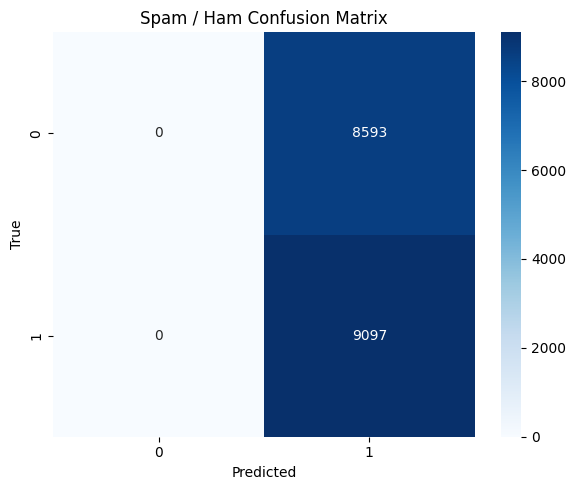

In [17]:
# 7) Final eval + confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_np, y_pred_np)
print("Confusion matrix:\n", cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Spam / Ham Confusion Matrix")
plt.tight_layout()
cm_path = os.path.join(BASE_DIR, "confusion_matrix_spam.png")
plt.savefig(cm_path)
print("Saved confusion matrix to", cm_path)

# 8) Save classifier
out_model_path = os.path.join(BASE_DIR, "spam_classifier_bert_small.pth")
torch.save(model.state_dict(), out_model_path)
print("Saved spam classifier to", out_model_path)